# Travel Salesman Problem (TSP)

The Travel Salesman Problem (TSP) is one of the most well-known and widely studied problems in the field of combinatorial optimization. The objective of the problem is simple to define: given a set of cities and the distances between each pair of them, the task is to determine the shortest possible route that visits each city exactly once and returns to the starting point.

Despite its apparent simplicity, TSP is classified as an NP-hard problem, meaning that the computational cost of finding the optimal solution increases exponentially as the number of cities grows. For this reason, solving the TSP efficiently becomes extremely challenging when dealing with medium or large instances.

----

# Project Aim

The main goal of this project is to analyze and compare two different approaches for solving the Traveling Salesman Problem:

Exhaustive / Brute Force Algorithm, which guarantees the optimal solution by evaluating all possible routes.

Ant Colony Optimization (ACO) Algorithm, a metaheuristic inspired by the natural behavior of ants searching for food, capable of finding high-quality approximate solutions in a reasonable time.

## Purpose of the Comparison

This project focuses on evaluating the differences between the two methods, particularly in terms of:

- Computational complexity

- Execution time

- Solution accuracy

- Scalability as the number of cities increases

---

## Imports

In [161]:
import numpy as np
import time
import itertools
import matplotlib.pyplot as plt
from IPython.display import clear_output, display

## Citys Definition

In [162]:
# 1. City Generation and Distance Matrix
def generate_data(n):
    cities = np.random.rand(n, 2)
    matrix = np.zeros((n, n))
    for i in range(n):
        for j in range(n):
            matrix[i, j] = np.linalg.norm(cities[i] - cities[j])
    return cities, matrix

In [165]:
N_CITIES = 12
cities, dist_matrix = generate_data(N_CITIES)

## Brute Force Algo.

Brute Force has a computational complexity of $O(n!)$. Each additional city multiplies the computation time by $n$. If 10 cities take 1 second, 11 cities take 11, 12 cities take 132... and 20 cities take centuries.

In [163]:
# 2. Exaustive Search (Brute Force)
def brute_force_tsp(dist_matrix):
    n = len(dist_matrix)
    cities = list(range(n))
    min_dist = float('inf')
    
    # Generate all permutations (always starting from city 0)
    for path in itertools.permutations(cities[1:]):
        current_path = [0] + list(path) + [0]
        dist = sum(dist_matrix[current_path[i], current_path[i+1]] for i in range(len(current_path)-1))
        if dist < min_dist:
            min_dist = dist
    return min_dist

## Ant Colony Optimization Algo.

The ACO has a complexity of $O(Iterations \times Ants \times n^2)$. This is nearly linear with respect to the computation time the user is willing to wait.

In [164]:
import numpy as np

class AntColonyOptimizer:
    def __init__(self, dist_matrix, n_ants=20, n_iterations=100, alpha=1, beta=2, rho=0.5, q=10):
        self.dist_matrix = dist_matrix
        self.n_cities = len(dist_matrix)
        self.n_ants = n_ants
        self.n_iterations = n_iterations
        self.alpha = alpha
        self.beta = beta
        self.rho = rho
        self.q = q
        self.pheromones = np.ones((self.n_cities, self.n_cities)) / self.n_cities

    def run(self, return_pheromone_history=False):
        best_path = None
        best_dist = float("inf")
        history_best_dist = []
        pheromone_history = []

        for _ in range(self.n_iterations):
            paths = self._generate_all_paths()
            self._update_pheromones(paths)

            if return_pheromone_history:
                pheromone_history.append(self.pheromones.copy())

            for path, dist in paths:
                if dist < best_dist:
                    best_dist = dist
                    best_path = path

            history_best_dist.append(best_dist)

        if return_pheromone_history:
            return best_path, best_dist, history_best_dist, pheromone_history
        return best_path, best_dist, history_best_dist

    def _generate_all_paths(self):
        all_paths = []
        for _ in range(self.n_ants):
            path = self._generate_path()
            dist = self._calculate_dist(path)
            all_paths.append((path, dist))
        return all_paths

    def _generate_path(self):
        path = [0]
        visited = {0}

        while len(path) < self.n_cities:
            i = path[-1]
            probs = self._calculate_probabilities(i, visited)
            next_city = np.random.choice(range(self.n_cities), p=probs)
            path.append(next_city)
            visited.add(next_city)

        path.append(0)  # tour chiuso
        return path

    def _calculate_probabilities(self, i, visited):
        tau = (self.pheromones[i] ** self.alpha)
        eta = (1.0 / (self.dist_matrix[i] + 1e-10)) ** self.beta

        mask = np.ones(self.n_cities)
        for v in visited:
            mask[v] = 0.0

        probs = tau * eta * mask
        s = probs.sum()
        if s <= 0:
            # fallback: scelta uniforme tra non visitate
            candidates = [k for k in range(self.n_cities) if k not in visited]
            probs = np.zeros(self.n_cities)
            probs[candidates] = 1 / len(candidates)
            return probs

        return probs / s

    def _update_pheromones(self, paths):
        self.pheromones *= (1 - self.rho)

        for path, dist in paths:
            deposit = self.q / (dist + 1e-12)
            for k in range(len(path) - 1):
                a, b = path[k], path[k + 1]
                self.pheromones[a, b] += deposit
                # Se vuoi TSP simmetrico (di solito sì), decommenta:
                #self.pheromones[b, a] += deposit

    def _calculate_dist(self, path):
        return sum(self.dist_matrix[path[i], path[i + 1]] for i in range(len(path) - 1))


## Comparison  

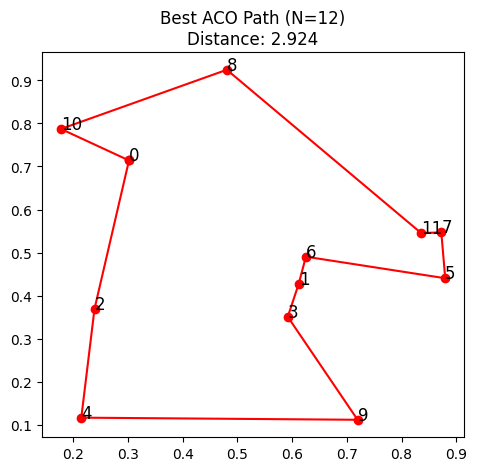

In [166]:
aco = AntColonyOptimizer(dist_matrix, n_ants=15, n_iterations=50)
best_path, best_dist, history = aco.run()

# 2. Best Path Visualization
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
x = cities[best_path, 0]
y = cities[best_path, 1]
plt.plot(x, y, 'ro-')
plt.title(f"Best ACO Path (N={N_CITIES})\nDistance: {best_dist:.3f}")
for i, (cx, cy) in enumerate(cities):
    plt.annotate(str(i), (cx, cy), fontsize=12)

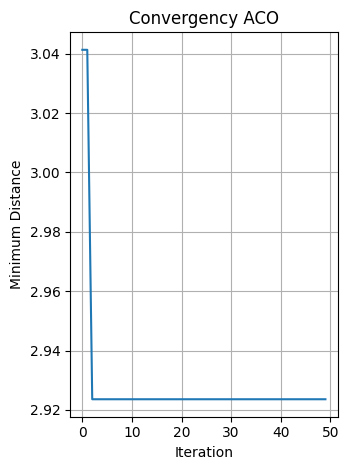

In [167]:
# 3. Convergency Plot
plt.subplot(1, 2, 2)
plt.plot(history)
plt.title("Convergency ACO")
plt.xlabel("Iteration")
plt.ylabel("Minimum Distance")
plt.grid(True)
plt.tight_layout()
plt.show()

In [168]:
# 4. BENCHMARKING
print("\n--- Comparative Time Analysis ---")
results_bf = []
results_aco = []
n_range = range(4, 12) # Brute force over 11 becomes extremely slow

for n in n_range:
    _, m = generate_data(n)
    
    start = time.time()
    brute_force_tsp(m)
    results_bf.append(time.time() - start)
    
    start = time.time()
    aco_test = AntColonyOptimizer(m, n_ants=10, n_iterations=20)
    aco_test.run()
    results_aco.append(time.time() - start)
    print(f"Completato N={n}")


--- Comparative Time Analysis ---
Completato N=4
Completato N=5
Completato N=6
Completato N=7
Completato N=8
Completato N=9
Completato N=10
Completato N=11


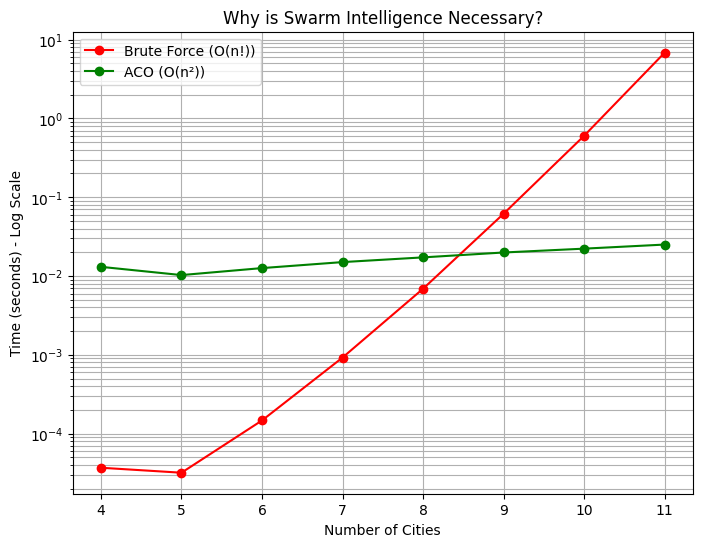

In [169]:
# Plot Finale di Confronto
plt.figure(figsize=(8, 6))
plt.plot(n_range, results_bf, 'r-o', label='Brute Force (O(n!))')
plt.plot(n_range, results_aco, 'g-o', label='ACO (O(n²))')
plt.yscale('log') # Scala logaritmica per evidenziare la differenza esplosiva
plt.xlabel('Number of Cities')
plt.ylabel('Time (seconds) - Log Scale')
plt.title('Why is Swarm Intelligence Necessary?')
plt.legend()
plt.grid(True, which="both", ls="-")
plt.show()

For $N=10$, the brute force must check $362,880$ paths. For $N=20$, the paths are $2,432,902,008,176,640,000$.  
If for $N=11$ the Brute Force takes 2 seconds and the ACO takes 0.05, the ACO is 40 times faster. For $N=20$, the ACO is billions of times faster because the Brute Force would never finish.

In [170]:
# --- TEST DI CONFRONTO ---
cities, dist_matrix = generate_data(N_CITIES)

print(f"--- Comparison between {N_CITIES} cities ---")
start = time.time()
bf_res = brute_force_tsp(dist_matrix)
print(f"Brute Force: {bf_res:.4f} in {time.time()-start:.4f} seconds")

start = time.time()
aco_res = AntColonyOptimizer(dist_matrix).run()[1]
print(f"ACO:         {aco_res:.4f} in {time.time()-start:.4f} seconds")

--- Comparison between 12 cities ---
Brute Force: 3.3132 in 79.9200 seconds
ACO:         3.3132 in 0.2942 seconds


In [171]:
# --- TEST SCALABILITÀ ---
N_LARGE = 50
cities_large, dist_matrix_large = generate_data(N_LARGE)
print(f"\n--- Scalability test of ACO on {N_LARGE} cities ---")
start = time.time()
aco_large = AntColonyOptimizer(dist_matrix_large).run()[1]
print(f"ACO on 50 cities: {aco_large:.4f} in {time.time()-start:.4f} seconds")
print("Note: Brute Force on 50 cities would take billions of years.")


--- Scalability test of ACO on 50 cities ---
ACO on 50 cities: 6.5142 in 1.4993 seconds
Note: Brute Force on 50 cities would take billions of years.


### The Trade-off (Speed ​​vs. Accuracy)

ACO is "faster" because it doesn't seek absolute perfection, but explores space intelligently.
- In tests with a few cities, you'll see that ACO almost always finds the same value as Brute Force, but in a fraction of the time.

### Parameters

The speed of the ACO is controllable. If you want more precision, you increase the "ants" or "iterations," but you will still be orders of magnitude faster than the exhaustive search.

## Animation of an ACO

In [172]:
np.random.seed(42)  # opzionale per riproducibilità

aco = AntColonyOptimizer(dist_matrix, n_ants=15, n_iterations=100, alpha=1, beta=2, rho=0.5, q=10)
best_path, best_dist, hist_best, ph_hist = aco.run(return_pheromone_history=True)

print("Best path achieved by Ant Colony Optimization:")
print(" -> ".join([f"City{i}" for i in best_path]))
print(f"\nTotal path length: {best_dist:.4f}")

Best path achieved by Ant Colony Optimization:
City0 -> City6 -> City1 -> City4 -> City3 -> City5 -> City7 -> City2 -> City9 -> City8 -> City11 -> City10 -> City0

Total path length: 3.3132


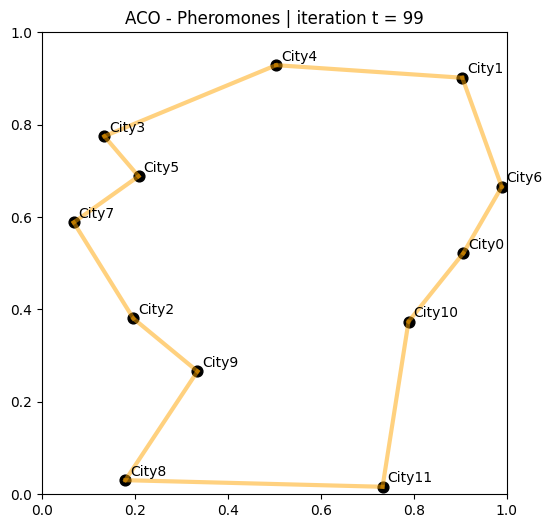

In [173]:
def animate_pheromones(cities, pheromone_history, pause=0.08, title_prefix="ACO - Pheromones"):
    fig, ax = plt.subplots(figsize=(6, 6))

    n = len(cities)

    for t, ph in enumerate(pheromone_history):
        ax.clear()

        max_ph = ph.max()
        if max_ph <= 0:
            max_ph = 1.0

        # archi (spessore proporzionale al feromone)
        for i in range(n):
            for j in range(i + 1, n):
                strength = max(ph[i, j], ph[j, i])
                lw = 3.0 * (strength / max_ph)
                ax.plot([cities[i, 0], cities[j, 0]],
                        [cities[i, 1], cities[j, 1]],
                        linewidth=lw,
                        alpha=0.5,
                        color="orange")

        # città + label
        ax.scatter(cities[:, 0], cities[:, 1], c="black", s=60)
        for i, (x, y) in enumerate(cities):
            ax.text(x + 0.01, y + 0.01, f"City{i}")

        ax.set_title(f"{title_prefix} | iteration t = {t}")
        ax.set_xlim(0, 1)
        ax.set_ylim(0, 1)

        clear_output(wait=True)
        display(fig)
        time.sleep(pause)

    plt.close(fig)

animate_pheromones(cities, ph_hist, pause=0.08)


---

## Outcome

Through experimental simulations and performance analysis, this work highlights how exact algorithms and heuristic approaches behave differently depending on the size of the problem, and it demonstrates why metaheuristics such as Ant Colony Optimization are commonly used in real-world optimization problems where exact methods are too expensive.